## Como desenvolver CNN, LSTM para Séries Temporais Univariadas

In [204]:
import numpy as np
import pandas as pd 
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt

Redes neurais de aprendizado profundo são capazes de aprender e extrair automaticamente características a partir de dados brutos. 
> modelos podem ser desenvolvidos diretamente sobre as observações brutas sem a necessidade direta de escalonar os dados usando normalização e padronização ou de tornar os dados estacionários por diferenciação.

In [205]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv')

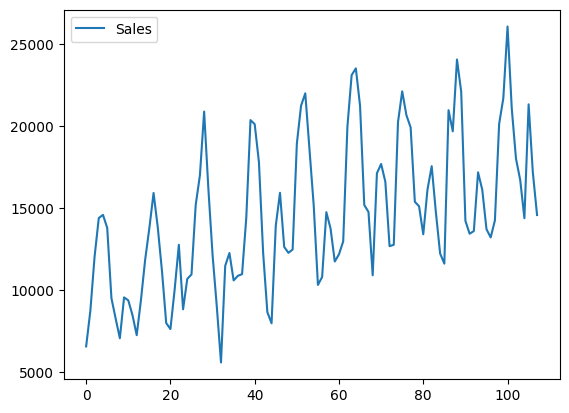

In [206]:
data.plot()
plt.show()

### Dividindo dados de treino e teste

In [207]:
data.shape

(108, 2)

In [208]:
from sklearn.preprocessing import StandardScaler
def scalonamento(serie, janela_tempo=5, no_lookahead=False):
    #if no_lookahead:
    #    return (serie - serie.rolling(janela_tempo).mean() / serie.rolling(janela_tempo).std()).dropna()

    scaler = StandardScaler()    

    scaler.fit(serie.values.reshape(-1, 1))

    return (scaler, scaler.transform(serie.values.reshape(-1, 1)))

In [269]:
def gerador_dados(series, janela_tempo=5, horizon=1, is_tnc=False):
    
    X, y = [], []
    for i in range(len(series) - janela_tempo - horizon + 1):
        Xi = series[i:i + janela_tempo]



        yi = series[i + janela_tempo:i + janela_tempo + horizon]
        X.append(Xi)
        y.append(yi)
    if is_tnc:
        return None
    
    if horizon >= 2:
        y = np.array(y)[:, :, 0]
    return np.array(X), y if type(y) is not list else np.array(y)

`horizonte` :

In [270]:
X, y = gerador_dados(data['Sales'].values.reshape(-1, 1), janela_tempo=5, horizon=1, is_tnc=False)

In [272]:
X.shape, y.shape

((103, 5, 1), (103, 1, 1))

In [273]:
train_size = 0.8 
train_index = int(train_size * X.shape[0])

xtrain, ytrain = X[:train_index], y[:train_index]
xtest, ytest = X[train_index:], y[train_index:]

In [274]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=8, kernel_size=4, activation='relu', input_shape=[None, 1]),
    keras.layers.Conv1D(filters=2, kernel_size=1, activation='relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [280]:
model.compile(loss='mse', optimizer='adam')

history = model.fit(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), verbose=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


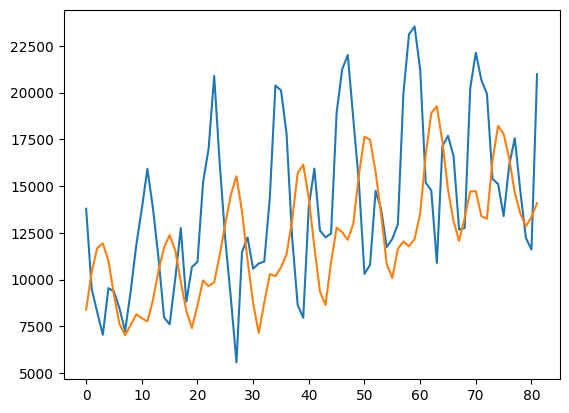

In [281]:
plt.plot(ytrain.reshape(-1))
plt.plot(model.predict(xtrain).reshape(-1))

### LSTM

In [289]:
X, y = gerador_dados(data['Sales'].values.reshape(-1, 1), janela_tempo=12, horizon=1, is_tnc=False)

scaler = StandardScaler()

X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

xtrain, ytrain = X[:train_index], y[:train_index]
xtest, ytest = X[train_index:], y[train_index:]

In [ ]:
model_cnn_lstm = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(40, recurrent_dropout=0.01),
    keras.layers.Dense(1),
])

model_cnn_lstm.compile(loss='mse', optimizer='adam')

history = model_cnn_lstm.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), verbose=0)

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


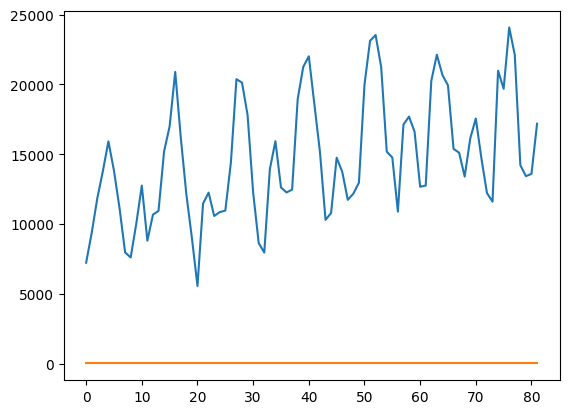

In [295]:
plt.plot(ytrain.reshape(-1))
plt.plot(model_cnn_lstm.predict(xtrain).reshape(-1))

###

In [3]:
import tensorflow as tf
from keras import layers, Model
import numpy as np

# Camada de Graph Convolution (simplificada)
class GraphConv(layers.Layer):
    def __init__(self, units):
        super(GraphConv, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer="glorot_uniform",
                                 trainable=True)

    def call(self, inputs, adjacency_matrix):
        x = tf.matmul(inputs, self.w)
        x = tf.matmul(adjacency_matrix, x)  # aplica adjacência
        return tf.nn.relu(x)

# Modelo TimeGNN simplificado
class TimeGNN(Model):
    def __init__(self, gcn_units, lstm_units, output_units):
        super(TimeGNN, self).__init__()
        self.gcn = GraphConv(gcn_units)
        self.lstm = layers.LSTM(lstm_units)
        self.dense = layers.Dense(output_units)

    def call(self, inputs, adjacency_matrix):
        # inputs: [batch, time, nodes, features]
        batch, time_steps, nodes, feat = inputs.shape
        outputs = []
        for t in range(time_steps):
            x_t = inputs[:, t, :, :]  # estado em t
            gcn_out = self.gcn(x_t, adjacency_matrix)  # [batch, nodes, gcn_units]
            outputs.append(gcn_out)

        seq = tf.stack(outputs, axis=1)  # [batch, time, nodes, gcn_units]
        seq = tf.reshape(seq, (batch, time_steps, -1))  # achata nós
        lstm_out = self.lstm(seq)
        return self.dense(lstm_out)

# ----------------- Exemplo de uso -----------------
# Definindo grafo (3 nós)
adjacency_matrix = tf.constant([
    [1., 0.5, 0.2],
    [0.5, 1., 0.3],
    [0.2, 0.3, 1.]
], dtype=tf.float32)

# Simulando dados: batch=16, time=10, nodes=3, features=2
X = np.random.rand(16, 10, 3, 2).astype(np.float32)
y = np.random.rand(16, 1).astype(np.float32)

# Criando e treinando modelo
model = TimeGNN(gcn_units=16, lstm_units=32, output_units=1)
model.compile(optimizer="adam", loss="mse")

history = model.fit((X, adjacency_matrix), y, epochs=5)
pred = model((X, adjacency_matrix))

print("Predição shape:", pred.shape)


FileNotFoundError: Could not find module 'c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\sklearn\.libs\vcomp140.dll' (or one of its dependencies). Try using the full path with constructor syntax.